In [1]:
import pandas as pd
import numpy as np
import random

# DataFrame Creation

In [2]:
SEED = 42 # answer to everything
# Don't really need reproducibility rn.
# np.random.seed(SEED)
# random.seed(SEED)

TRAIN_FRAC = 0.3
PUBLIC_LEADERBOARD_FRAC = 0.2
PRIVATE_LEADERBOARD_FRAC = 0.5
assert TRAIN_FRAC + PUBLIC_LEADERBOARD_FRAC + PRIVATE_LEADERBOARD_FRAC == 1, "Fractions must sum to 1"
N_TRAIN_SAMPLES = 10000
N_SAMPLES = int(N_TRAIN_SAMPLES // TRAIN_FRAC)
print(f"Total number of samples: {N_SAMPLES}")

PUBLIC_PRIVATE_SPLIT = 0.3 # Fraction of samples used for the public dataset
TEST_TRAIN_SPLIT = 0.2 # Fraction of samples used for the test set

ID_VARIABLE_NAME = "ID" # Name of the ID variable.
TARGET_VARIABLE_NAME = "y" # Name of the target variable.

INITIAL_NOISE = 0.1 # Previously was 0.3
FINAL_NOISE = 0.05 # Added to the final target

CAT_ERROR_PROB = 0.1 # Probability of categorical error
TRAIN_NAN_PROB = 0.08
PUBLIC_NAN_PROB = 0.12
PRIVATE_NAN_PROB = 0.15

ARTIFICIAL_TARGET_MULTIPLIER = 1000

DATA_DIR = "data"

Total number of samples: 33333


In [3]:
class cds:
    def __init__(self, weight: int) -> None:
        self.weight = weight
        
        # Nominal
        types = ['jut', 'kiv', 'tir', 'vel', 'qou']
        types_p = [0.2, 0.3, 0.2, 0.2, 0.1]
        type_col = np.random.choice(types, N_SAMPLES, p=types_p)

        # Ordinal
        matter = { # frequency, strength
            'corro': (6, 0),
            'corroyi': (5, 1),
            'sfer': (5, 2),
            'black corru': (3, 1),
            'corruskivi': (2, 10),
            'corrutir': (1, 10),
            'corrutir vel': (1, 12),
            'satik cyst': (5, 15),
            'pale corru': (0, 30),
        }
        matter_f_sum = sum(freq for freq, _ in matter.values())
        matter_p = [freq / matter_f_sum for freq, _ in matter.values()]
        matter_names = list(matter.keys())
        matter_col = np.random.choice(
            matter_names,
            N_SAMPLES,
            p=matter_p
        )

        # Ordinal
        mindspike_versions = {'tonga': 0, 'karbon': 1, 'silikon': 2, 'kristal': 3, 'nan': 4} # Replace 'nan' with an actual NaN later.
        mindspike_v_col = np.random.choice(
            list(mindspike_versions.keys()),
            N_SAMPLES,
            p=[0.1, 0.2, 0.2, 0.4, 0.1]
        )

        effect_matter = np.array([matter[m_name][1] for m_name in matter_col])
        effect_mindspike = np.array([mindspike_versions[m_name] for m_name in mindspike_v_col])
        y = effect_matter + effect_mindspike + np.random.normal(0, INITIAL_NOISE, N_SAMPLES)

        for i in range(N_SAMPLES):
            match type_col[i]:
                case 'jut':
                    y[i] *= 1.5
                case 'kiv':
                    y[i] *= 0.5
                case 'tir':
                    y[i] = 0
                case 'vel':
                    y[i] = np.sin(y[i])
                case 'qou':
                    y[i] *= 3

        min_y = y.min()
        max_y = y.max()
        if min_y == max_y:
            y = np.zeros_like(y)
        else:
            y = (y - min_y) / (max_y - min_y)  # Normalize y to [0, 1]

        self.X = pd.DataFrame({
            'type': type_col,
            'matter': matter_col,
            'mindspike': mindspike_v_col,
        })
        self.y = pd.Series(y, name='cat_y')

        # Replace 'nan' string in mindspike with actual NaN
        self.X['mindspike'] = self.X['mindspike'].replace('nan', np.nan)

        # Induce categorical errors
        n_rows = self.X.shape[0]
        n_cat_errors = int(n_rows * CAT_ERROR_PROB)

        # Randomly choose pairs of indices
        error_row_indices = np.random.choice(self.X.index, n_cat_errors, replace=True)

        for idx in error_row_indices:
            match np.random.choice(2):
                case 0:
                    self.X.at[idx, 'type'] = self.X.at[idx, 'type'] + 'skin'
                case 1:
                    self.X.at[idx, 'mindspike'] = 'ERROR'

In [4]:
from sklearn.datasets import (
    make_moons, make_circles, make_blobs, make_classification, make_hastie_10_2,
    make_friedman1, make_friedman2, make_friedman3, make_regression
)
#from sklearn.preprocessing import MinMaxScaler
from typing import Callable

class ds:
    def __init__(self, weight: float, name: str, generator: Callable[[], tuple[np.ndarray, np.ndarray]]):
        self.weight: float = weight
        self.name: str = name

        self.raw_X: np.ndarray
        self.raw_y: np.ndarray
        self.raw_X, self.raw_y = generator()

        min_y = self.raw_y.min()
        max_y = self.raw_y.max()
        if min_y == max_y:
            self.raw_y = np.zeros_like(self.raw_y)
        else:
            self.raw_y = (self.raw_y - min_y) / (max_y - min_y)  # Normalize y to [0, 1]

        self.X: pd.DataFrame = pd.DataFrame(
            self.raw_X,
            columns=[
                f"{self.name}_{i+1}" for i in range(self.raw_X.shape[1])
            ]
        )
        self.y: pd.Series = pd.Series(self.raw_y, name="{self.name}_y")

    
    def __hash__(self):
        return hash(self.name)

    def __eq__(self, other):
        return isinstance(other, ds) and self.name == other.name

# Make sure each has a unique name.
DATASETS: list[ds | cds] = [
    ds(4, "moon",      lambda: make_moons(n_samples=N_SAMPLES, noise=INITIAL_NOISE, random_state=SEED)),
    ds(3, "circle",    lambda: make_circles(n_samples=N_SAMPLES, noise=INITIAL_NOISE, factor=0.6, random_state=SEED)),
    ds(2, "blob",      lambda: make_blobs(n_samples=N_SAMPLES, centers=3, n_features=2, random_state=SEED, return_centers=False)), # type: ignore # return_centers=False to avoid returning centers
    ds(2, "hastie",    lambda: make_hastie_10_2(n_samples=N_SAMPLES, random_state=SEED)),
    ds(2, "friedman1", lambda: make_friedman1(n_samples=N_SAMPLES, noise=INITIAL_NOISE, random_state=SEED)),
    ds(2, "friedman2", lambda: make_friedman2(n_samples=N_SAMPLES, noise=INITIAL_NOISE, random_state=SEED)),
    ds(2, "friedman3", lambda: make_friedman3(n_samples=N_SAMPLES, noise=INITIAL_NOISE, random_state=SEED)),
    cds(2),
    ds(1, "class",     lambda: make_classification(n_samples=N_SAMPLES, n_features=10, n_informative=4, n_redundant=3, n_repeated=2, n_classes=4, class_sep=0.5, flip_y=0.2, weights=[0.6, 0.2, 0.1, 0.1], random_state=SEED)),
    ds(1, "reg",       lambda: make_regression(n_samples=N_SAMPLES, n_features=5, n_informative=3, noise=INITIAL_NOISE, random_state=SEED, coef=False)), # type: ignore # coef=False to avoid returning coefficients
]

In [5]:
df = pd.concat([d.X for d in DATASETS], axis=1)
normalized_weights = np.array([d.weight for d in DATASETS], dtype=np.float64) # dtype=np.float64 for division in the next line
normalized_weights /= normalized_weights.sum()

y_final = sum(DATASETS[i].y * normalized_weights[i] for i in range(len(DATASETS)))
y_final += np.random.normal(0, FINAL_NOISE, size= N_SAMPLES) # Some small, random noise to the final target
df[TARGET_VARIABLE_NAME] = y_final * ARTIFICIAL_TARGET_MULTIPLIER # Scale the target to a larger range for larger RMSEs

id = pd.Series(np.arange(N_SAMPLES), name=ID_VARIABLE_NAME)
df[ID_VARIABLE_NAME] = id
# Making sure the ID column is the first column; makes the analysis prettier.
cols = [ID_VARIABLE_NAME] + [col for col in df.columns if col != ID_VARIABLE_NAME]
df = df[cols]

# Analysis

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

df.tail()
import pandas as pd

# Suppose your dataset is in df
non_numeric_cols = df.select_dtypes(exclude=['number']).columns.tolist()

print("Non-numeric columns:", non_numeric_cols)
df_num = df.select_dtypes(include=['number']).copy()

print("Shape of df_num:", df_num.shape)
print("Numeric columns:", df_num.columns.tolist())
df.head()

Non-numeric columns: ['type', 'matter', 'mindspike']
Shape of df_num: (33333, 51)
Numeric columns: ['ID', 'moon_1', 'moon_2', 'circle_1', 'circle_2', 'blob_1', 'blob_2', 'hastie_1', 'hastie_2', 'hastie_3', 'hastie_4', 'hastie_5', 'hastie_6', 'hastie_7', 'hastie_8', 'hastie_9', 'hastie_10', 'friedman1_1', 'friedman1_2', 'friedman1_3', 'friedman1_4', 'friedman1_5', 'friedman1_6', 'friedman1_7', 'friedman1_8', 'friedman1_9', 'friedman1_10', 'friedman2_1', 'friedman2_2', 'friedman2_3', 'friedman2_4', 'friedman3_1', 'friedman3_2', 'friedman3_3', 'friedman3_4', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6', 'class_7', 'class_8', 'class_9', 'class_10', 'reg_1', 'reg_2', 'reg_3', 'reg_4', 'reg_5', 'y']


,ID,moon_1,moon_2,circle_1,circle_2,blob_1,blob_2,hastie_1,hastie_2,hastie_3,...,class_7,class_8,class_9,class_10,reg_1,reg_2,reg_3,reg_4,reg_5,y
0,0,0.357426,-0.322764,0.001873,0.505807,-1.725027,9.043159,0.496714,-0.138264,0.647689,...,-0.372307,-2.089761,0.145285,2.250762,0.075630,-0.113823,-0.618728,-1.310186,-0.859761,640.034399
1,1,0.220267,1.015018,-0.860499,0.221977,-5.718679,-6.160025,-0.463418,-0.465730,0.241962,...,0.479102,2.468947,2.019526,-0.086243,-0.608845,0.584451,-0.482178,1.346586,-1.267107,323.609979
2,2,0.320973,0.925499,-0.801558,0.512510,-7.815199,-8.534208,1.465649,-0.225776,0.067528,...,-0.834672,-1.396733,-4.751818,0.200500,0.029743,1.374305,0.245236,-1.373666,0.073546,225.815092
3,3,0.826164,0.221299,0.783882,0.384602,-6.570935,-6.766553,-0.601707,1.852278,-0.013497,...,-0.266756,-0.504224,-0.491915,0.751555,-0.160917,-0.722556,-0.413778,-0.625538,-0.017230,311.942782
4,4,1.342571,-0.559106,-0.465867,-0.602006,-2.226748,8.289901,0.738467,0.171368,-0.115648,...,0.100664,-2.895433,-3.965414,-1.647167,0.345430,-0.679394,-1.083462,-1.789171,-0.852532,614.568096


<Axes: >

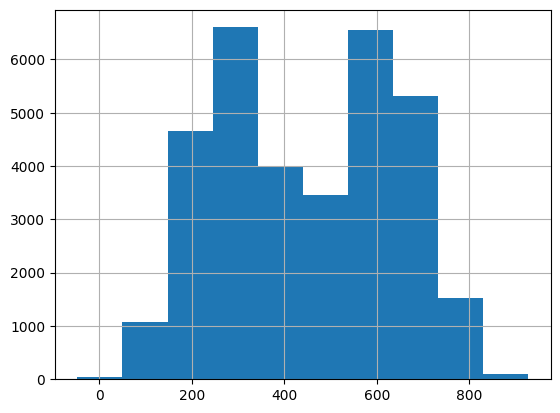

In [7]:
df['y'].hist()

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


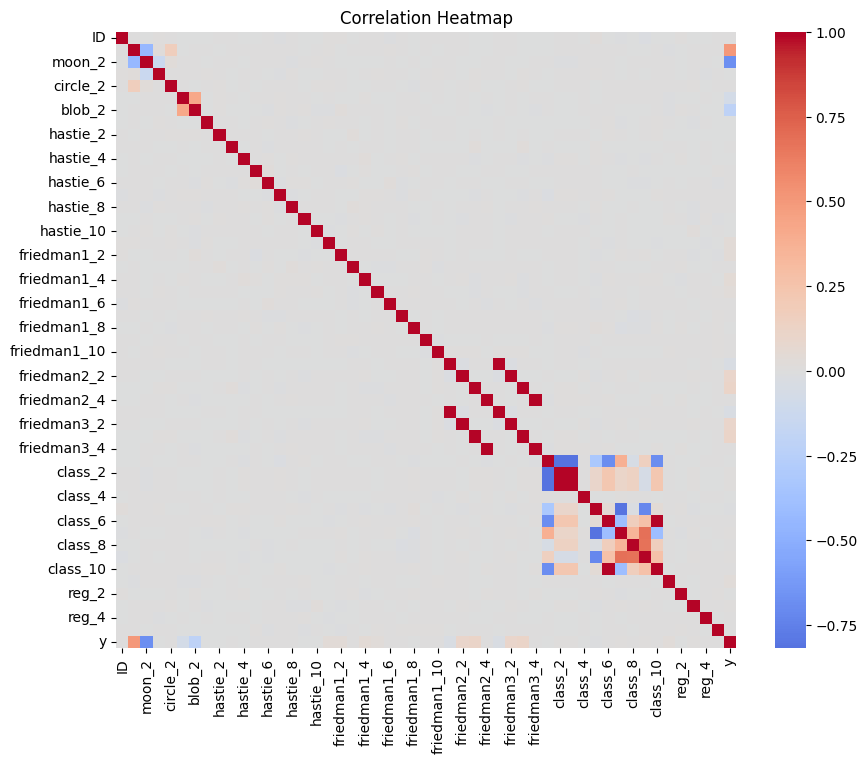

In [8]:
# ---------------------------
# Correlation Heatmap (numeric features only)
# ---------------------------
plt.figure(figsize=(10,8))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, cmap='coolwarm', center=0, annot=False)
plt.title("Correlation Heatmap")
plt.show()

**Encoding cat_cols**

In [9]:
# Get non-numeric columns
non_num_cols = df.select_dtypes(exclude=['number']).columns

print("Non-numeric columns:")
print(non_num_cols.tolist())




Non-numeric columns:
['type', 'matter', 'mindspike']


In [10]:
for col in non_num_cols:
    print(f"\nColumn: {col}")
    print(df[col].head())  # Show first 5 values



Column: type
0        kiv
1        vel
2        kiv
3    velskin
4        vel
Name: type, dtype: object

Column: matter
0         corro
1          sfer
2    satik cyst
3          sfer
4          sfer
Name: matter, dtype: object

Column: mindspike
0      ERROR
1    kristal
2    kristal
3    kristal
4     karbon
Name: mindspike, dtype: object


In [11]:
non_num_cols = df.select_dtypes(exclude=['number']).columns

df_one_hot = pd.get_dummies(df, columns=non_num_cols, dtype=int)

print("Non-numeric columns after encoding:",
      df_one_hot.select_dtypes(exclude=['number']).columns.tolist())


Non-numeric columns after encoding: []


In [12]:
df_one_hot.head()

,ID,moon_1,moon_2,circle_1,circle_2,blob_1,blob_2,hastie_1,hastie_2,hastie_3,...,matter_corruskivi,matter_corrutir,matter_corrutir vel,matter_satik cyst,matter_sfer,mindspike_ERROR,mindspike_karbon,mindspike_kristal,mindspike_silikon,mindspike_tonga
0,0,0.357426,-0.322764,0.001873,0.505807,-1.725027,9.043159,0.496714,-0.138264,0.647689,...,0,0,0,0,0,1,0,0,0,0
1,1,0.220267,1.015018,-0.860499,0.221977,-5.718679,-6.160025,-0.463418,-0.465730,0.241962,...,0,0,0,0,1,0,0,1,0,0
2,2,0.320973,0.925499,-0.801558,0.512510,-7.815199,-8.534208,1.465649,-0.225776,0.067528,...,0,0,0,1,0,0,0,1,0,0
3,3,0.826164,0.221299,0.783882,0.384602,-6.570935,-6.766553,-0.601707,1.852278,-0.013497,...,0,0,0,0,1,0,0,1,0,0
4,4,1.342571,-0.559106,-0.465867,-0.602006,-2.226748,8.289901,0.738467,0.171368,-0.115648,...,0,0,0,0,1,0,1,0,0,0


In [13]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.utils import all_estimators

target = "y"

# Limit to first 5,000 rows
df_sample = df.head(5000)

# Features / target
X = df_sample.drop(columns=[target])
y = df_sample[target]

# Column types
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X.select_dtypes(include=['number']).columns.tolist()

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

tree_models = [
    'DecisionTreeRegressor', 'RandomForestRegressor', 'ExtraTreesRegressor',
    'GradientBoostingRegressor', 'HistGradientBoostingRegressor',
    'AdaBoostRegressor', 'BaggingRegressor'
]
all_regressors = all_estimators(type_filter="regressor")

def run_models(X_train, X_test, y_train, y_test, encode=False):
    results = []
    for name, RegressorClass in all_regressors:
        try:
            model = RegressorClass()

            if encode:
                if name in tree_models:
                    preprocessor = ColumnTransformer([
                        ("cat", OneHotEncoder(handle_unknown='ignore'), cat_cols),
                        ("num", "passthrough", num_cols)
                    ])
                else:
                    preprocessor = ColumnTransformer([
                        ("cat", OneHotEncoder(handle_unknown='ignore'), cat_cols),
                        ("num", StandardScaler(), num_cols)
                    ])
                pipe = Pipeline([("prep", preprocessor), ("model", model)])
            else:
                if name in tree_models:
                    pipe = Pipeline([("model", model)])
                else:
                    preprocessor = ColumnTransformer([
                        ("num", StandardScaler(), num_cols)
                    ], remainder='drop')
                    pipe = Pipeline([("prep", preprocessor), ("model", model)])

            pipe.fit(X_train, y_train)
            score = r2_score(y_test, pipe.predict(X_test))
            results.append((name, score))
        except Exception:
            pass

    return sorted(results, key=lambda x: x[1], reverse=True)

# Run both
results_no_enc = run_models(X_train, X_test, y_train, y_test, encode=False)
results_with_enc = run_models(X_train, X_test, y_train, y_test, encode=True)

# Output top 5
print("\nTop 5 models WITHOUT encoding:")
for name, score in results_no_enc[:5]:
    print(f"{name}: R² = {score:.4f}")

print("\nTop 5 models WITH encoding:")
for name, score in results_with_enc[:5]:
    print(f"{name}: R² = {score:.4f}")


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_quantile.py:186: FutureWarning: The default solver will change from 'interior-point' to 'highs' in version 1.4. Set `solver='highs'` or to the desired solver to silence this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_quantile.py:186: FutureWarning: The default solver will change from 'interior-point' to 'highs' in version 1.4. Set `solver='highs'` or to the desired solver to silence this warning.
  warnings.warn(



Top 5 models WITHOUT encoding:
ExtraTreeRegressor: R² = 0.6303
SGDRegressor: R² = 0.6193
Ridge: R² = 0.6183
RidgeCV: R² = 0.6182
HuberRegressor: R² = 0.6182

Top 5 models WITH encoding:
HistGradientBoostingRegressor: R² = 0.8751
ExtraTreesRegressor: R² = 0.8373
RandomForestRegressor: R² = 0.8368
GradientBoostingRegressor: R² = 0.8301
BaggingRegressor: R² = 0.8172


# CSV Creation

In [14]:
# Shuffle columns, keeping the target column at the end and ID at the beginning
cols = df.columns.tolist()
df = df[[cols[0]] + np.random.permutation(cols[1:-1]).tolist() + [cols[-1]]]

In [15]:
# Thematic renaming of columns
renaming = {
    ID_VARIABLE_NAME: 'LOCAL_IDENTIFIER',
    TARGET_VARIABLE_NAME: 'CORRUCYSTIC_DENSITY',

    'moon_1': 'v0rt3X',
    'moon_2': 'v1rt3X',
    'circle_1': 'r1Ng',
    'circle_2': 'r2Ng',
    'blob_1': 'b1oRb13',
    'blob_2': 'b2oRb13',

    'mindspike': 'MINDSPIKE',
}

generic_cols = [col for col in df.columns if col not in renaming]

import string

def random_gibberish(mean_length: int = 4, std_length = 3) -> str:
    length = max(3, int(round(random.gauss(mean_length, std_length))))
    chars = string.ascii_letters + string.digits + string.punctuation
    return ''.join(random.choice(chars) for _ in range(length))

gibberish_mapping = {col: random_gibberish() for col in generic_cols}

final_mapping = {**renaming, **gibberish_mapping}

df.rename(columns=final_mapping, inplace=True)

In [16]:
N_PUBLIC_SAMPLES = int(N_SAMPLES * PUBLIC_LEADERBOARD_FRAC)
train = df.iloc[:N_TRAIN_SAMPLES]
public = df.iloc[N_TRAIN_SAMPLES:N_TRAIN_SAMPLES + N_PUBLIC_SAMPLES]
private = df.iloc[N_TRAIN_SAMPLES + N_PUBLIC_SAMPLES:]

In [17]:
# Populate NaNs
# WARNING: Renaming has taken place.

def add_nans(df: pd.DataFrame, prob, add_on_target: bool = False) -> pd.DataFrame:
    # Make some cells NaN with a given probability
    id = df[renaming[ID_VARIABLE_NAME]]
    df.drop(columns=[renaming[ID_VARIABLE_NAME]], inplace=True)
    if add_on_target:
        y = df[renaming[TARGET_VARIABLE_NAME]]
        df.drop(columns=[renaming[TARGET_VARIABLE_NAME]], inplace=True)
    
    n_cells = df.size
    n_nan = int(n_cells * prob)

    # Randomly choose pairs of indices
    nan_indices = (
        np.random.choice(df.index, n_nan, replace=True),
        np.random.choice(df.columns, n_nan, replace=True)
    )

    # Assign NaN
    for row, col in zip(*nan_indices):
        df.loc[row, col] = np.nan

    df = pd.concat([id, df], axis=1)  # Reattach the ID column
    if add_on_target:
        df[renaming[TARGET_VARIABLE_NAME]] = y # type: ignore
    return df

train = add_nans(train, prob=TRAIN_NAN_PROB, add_on_target=False)
public = add_nans(public, prob=PUBLIC_NAN_PROB, add_on_target=True)
private = add_nans(private, prob=PRIVATE_NAN_PROB, add_on_target=True)

/tmp/ipykernel_36/4020265657.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=[renaming[ID_VARIABLE_NAME]], inplace=True)
/tmp/ipykernel_36/4020265657.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=[renaming[ID_VARIABLE_NAME]], inplace=True)
/tmp/ipykernel_36/4020265657.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=[renaming[TARGET_VARIABLE_NAME]], inplace=True)
/tmp/ipyker

In [18]:
# Save the datasets to CSV files
from datetime import datetime
timestamp = datetime.now().strftime("%d_%H-%M-%S")

train.to_csv(f"{DATA_DIR}/{timestamp}_train.csv")
public.to_csv(f"{DATA_DIR}/{timestamp}_public.csv")
private.to_csv(f"{DATA_DIR}/{timestamp}_private.csv")

OSError: Cannot save file into a non-existent directory: 'data'

In [ ]:
for name, df in [('train', train), ('public', public), ('private', private)]:
    col = renaming[TARGET_VARIABLE_NAME]
    print(name, "target missing:", df[col].isna().sum(), "/", len(df))